# DL Indaba Practical 3
# Convolutional Neural Networks

**Introduction**

In this practical we will cover the basics of convolutional neural networks, or "ConvNets". ConvNets were invented in the 1990s and have had tremendous success especially with vision (although they have also been used to great success in speech processing pipelines, and more recently, for machine translation). 

We will work to build our mathematical and algorithmic intuition around the "convolution" operation. Then we will construct a deep feedforward convolutional model with which we can classify MNIST digits with over 99% accuracy (our best model yet!).

**What is expected of you:**

* **TODO: Stipulate desired outcomes (with time-limits).**

In [0]:
# Import TensorFlow and some other libraries we'll be using.
import datetime
import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

# Import Matplotlib and set some defaults
from matplotlib import pyplot as plt
plt.ioff()
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Download the MNIST dataset onto the local machine.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# ConvNet Architectures
When modelling an image using a regular feed-forward network, we quickly find that the number of model parameters grows exponentially. For example, our 2 layer MNIST feed-forward model from the previous practical already had over 600 000 parameters! Imagine how many paramaters a deeper architecture with larger, colour images would require? 

ConvNets address this model parameter issue by making the assumption that the inputs are images. The two key differences between a ConvNet and a Feed-forward network are that:
* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth (depth here means the depth of an activation volume, not the depth of a deep neural network!)
* The neurons in each layer are only connected to a small region of the layer before it

Generally a ConvNet architecture is made up of different types of layers, the most common being **convolutional layers**, **pooling layers** and **fully connected layers** that we encountered in the last practical. 

ConvNet architectures were key to the tremendous success of deep learning in machine vision. In particular, the first deep learning model to win the ImageNet competition was called AlexNet, which had 5 convolutional layers followed by 3 fully connected. Later winners included GoogLeNet and ResNet which also used batch normalisation, a technique we will see in this practical.

We will start by implementing the forward and backward passes of these layers in Numpy to get a good sense for how they work. Afterwards, we will implement a full ConvNet classifier in TensorFlow that we will apply to the MNIST dataset. This model should give us the best test accuracy we've seen so far! 

## Convolutional Layers
A convolutional layer maps an **input volume** to an **output volume** through a set of **learnable filters**, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size 5x5x3). During the forward pass, we colvolve ("slide") each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have a set of filters, and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension to produce the output volume.

### What size is the output volume?
The size of the output volume is controlled by the hyperparameters of the convolutional layer:
* **Filter Size** (F) defines the width and height of the filters in the layer. Note that filters always have the same depth as the inputs to the layer.  
* **Depth** (D) of the layer defines the number of filters in the layer. 
* **Stride** (S) defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used. 
* **Padding** (P) refers to the number of 0 pixels we add to the input volume along the width and height dimensions. This parameter is useful in that it gives us more control over the desired size of the output volume and in fact is often used to ensure that the output volume has the same width and height as the input volume. 

Together with the width and height of the input volume, $W = (w, h)$, we can calculate the size of the output volume as follows:

$(W−F+2P)/S+1$

Make sure you understand **why** this is the case! 

### Implementing the forward pass
Lets implement the forward pass of a convolutional layer in Numpy:

In [0]:
# Conv layer forward pass
def convolutional_forward(X, W, b, filter_size, depth, stride, padding):
  # W is [filter_size, filter_size, input_depth, output_depth]
  
  batch_size, input_width, input_height, input_depth = X.shape
  
  # Check that the weights are of the expected shape
  assert W.shape[0] == filter_size and W.shape[1] == filter_size
  
  # QUESTION: Calculate the width and height of the output
  # output_width = ...
  # output_height = ...
  #
  # ANSWER:
  output_width = (input_width - filter_size + 2*padding) / stride + 1
  output_height = (input_height - filter_size + 2*padding) / stride + 1
  ####
  
  # Apply padding to the width and height dimensions of the input
  X_padded = np.pad(X, ((0,0), (padding, padding), (padding, padding), (0,0)), 'constant')
  
  # Allocate the output Tensor
  out = np.zeros((batch_size, output_width, output_height, depth))
  
  # NOTE: The following is very inefficient, but most clearly illustrates the convolutional operation
  
  for w in range(output_width):  # Loop over the output width dimension
    for h in range(output_height):  # Loop over the output height dimension
      
      # Select the current block in the input that the filter will be applied to 
      block_width_start = w*stride
      block_width_end = block_width_start+filter_size

      block_height_start = h*stride
      block_height_end = block_height_start + filter_size

      block = X_padded[:, block_width_start:block_width_end, block_height_start:block_height_end, :]
      
      for f in range(depth):  # Loop over the filters in the layer (output depth dimension)
        
        filter_weights = W[:, :, :, f]
        # QUESTION: Apply the filter to the block over all inputs in the batch
        # out[:, w, h, f] = ...
        # HINT: Have a look at numpy's sum function and pay attention to the axis parameter
        # ANSWER:
        out[:, w, h, f] = np.sum(block * filter_weights, axis=(1,2,3)) + b[f]
        ###
      
  return out


Let's test our layer on some dummy data:

In [0]:
### Hyperparameters
batch_size = 2
input_width = 4
input_height = 4
input_depth = 3
filter_size = 4
output_depth = 3
stride = 2
padding = 1
###

# Create a helper function that calculates the relative error between two arrays
def relative_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Define the shapes of the input and weights
input_shape = (batch_size, input_width, input_height, input_depth)
w_shape = (filter_size, filter_size, input_depth, output_depth)

# Create the dummy input
X = np.linspace(-0.1, 0.5, num=np.prod(input_shape)).reshape(input_shape)

# Create the weights and biases
W = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=output_depth)

# Get the output of the convolutional layer
out = convolutional_forward(X, W, b, filter_size, output_depth, stride, padding)

correct_out = np.array(
    [[[[8.72013250e-02, 2.37300699e-01, 3.87400074e-01],
       [1.34245123e-01, 2.86133235e-01, 4.38021347e-01]],
      [[8.21928598e-02, 2.39447184e-01, 3.96701509e-01],
       [4.47552448e-04, 1.59490615e-01, 3.18533677e-01]]],
     [[[1.11179021e+00, 1.29050939e+00, 1.46922856e+00],
       [9.01255797e-01, 1.08176371e+00, 1.26227162e+00]],
      [[7.64688995e-02, 2.62343025e-01, 4.48217151e-01],
       [-2.62854619e-01, -7.51917556e-02, 1.12471108e-01]]]])

# Compare your output to the "correct" ones 
# The difference should be around 2e-8 (or lower)

print 'Testing convolutional_forward'
diff = relative_error(out, correct_out)
if diff <= 2e-8:
  print 'PASSED'
else:
  print 'The difference of %s is too high, try again' % diff

Testing convolutional_forward
PASSED


### The derivative of a convolutional layer
Assume we have some final loss function L and have computed the deriviative of this loss up to the output of our convolutional layer. In order to update the parameters of our layer, we require the derivative of the final loss with respect to the weights and biases of the convolutional layer. We also require the derivative with respect to the inputs of the layer in order to propagate the error back to the preceding layers. You should be able to derive the following expressions for these 3 deriviatives: 

(Remember that we need to sum the contributions from all terms in which the weights occur!)

Lets implement this in Numpy:

In [0]:
def convolutional_backward(dout, X, W, b, filter_size, depth, stride, padding):
  batch_size, input_width, input_height, input_depth = X.shape
  
  # Apply padding to the width and height dimensions of the input
  X_padded = np.pad(X, ((0,0), (padding, padding), (padding, padding), (0,0)), 'constant')
  
  # Calculate the width and height of the forward pass output
  output_width = (input_width - filter_size + 2*padding) / stride + 1
  output_height = (input_height - filter_size + 2*padding) / stride + 1
  
  # Allocate output arrays
  # QUESTION: What is the shape of dx? dw? db?
  # ANSWER: ...
  dx_padded = np.zeros_like(X_padded) 
  dw = np.zeros_like(W)
  db = np.zeros_like(b)
  
  # QUESTION: Can you write a mathematical expression for the derivative with respect to b? 
  db = np.sum(dout, axis = (0, 1, 2))
  
  # QUESTION: Can you write a mathematical expression for the deriviative with respect to X? and W? 
  # HINT: Remember that W is shared, so you need to sum the contributions from all terms in which W occurs
  
  for w in range(output_width):
    for h in range(output_height):
      
      # Select the current block in the input that the filter will be applied to 
      block_width_start = w*stride
      block_width_end = block_width_start+filter_size

      block_height_start = h*stride
      block_height_end = block_height_start + filter_size

      block = X_padded[:, block_width_start:block_width_end, block_height_start:block_height_end, :]
      
      for f in range(depth):
        dw[:,:,:,f] += np.sum(block*(dout[:,w,h,f])[:,None,None,None], axis=0)
        
      # TODO(avishkar): Change this to not use einsum
      dx_padded[:,block_width_start:block_width_end, block_height_start:block_height_end, :] += np.einsum('ij,klmj->iklm', dout[:,w, h,:], W)
      
    # Now we remove the padding to arrive at dx
    dx = dx_padded[:,padding:-padding, padding:-padding, :]
    
  return dx, dw, db
  

Finally, we test the backward pass using numerical gradient checking.

In [0]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    
    # QUESTION: Can you describe intuitively what this function is doing? 
    
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

np.random.seed(231)

dout = np.random.randn(2, 2, 2, 3)

dx_num = eval_numerical_gradient_array(lambda x: convolutional_forward(X, W, b, filter_size, output_depth, stride, padding), X, dout)
dw_num = eval_numerical_gradient_array(lambda w: convolutional_forward(X, W, b, filter_size, output_depth, stride, padding), W, dout)
db_num = eval_numerical_gradient_array(lambda b: convolutional_forward(X, W, b, filter_size, output_depth, stride, padding), b, dout)

out = convolutional_forward(X, W, b, filter_size, output_depth, stride, padding)
dx, dw, db = convolutional_backward(dout, X, W, b, filter_size, output_depth, stride, padding)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')

dx_diff = relative_error(dx, dx_num)
if dx_diff < 1e-8:
  print 'dx check: PASSED'
else:
  print 'The difference of %s on dx is too high, try again!' % dx_diff
  
dw_diff = relative_error(dw, dw_num)
if dw_diff < 1e-8:
  print 'dw check: PASSED'
else:
  print 'The difference of %s on dw is too high, try again!' % dw_diff
  
db_diff = relative_error(db, db_num)
if db_diff < 1e-8:
  print 'db check: PASSED'
else:
  print 'The difference of %s on db is too high, try again!' % db_diff
  

Testing conv_backward_naive function
dx check: PASSED
dw check: PASSED
db check: PASSED


## (Max) Pooling Layers
The purpose of a pooling layer is to is to reduce the spatial size of the representation and therefore control the number of parameters in the network. A pooling layer has no trainable parameters itself. It applies some 2D aggegation operation (usually a MAX, but others like average may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height. 

The output volume of a pooling layer alwyas has the same depth as the input volume. The width and height are calcualted as follows:
$(W−F)/S+1$ where W is the width/height of the 

### Implementing the forward pass
We again implement this in Numpy:

In [0]:
def max_pool_forward(X, pool_size, stride):
  batch_size, input_width, input_height, input_depth = X.shape
  
  # Calculate the output dimensions
  output_width = (input_width - pool_size)/stride + 1
  output_height = (input_height - pool_size)/stride + 1
  
  # Allocate the output array
  out = np.zeros((batch_size, output_width, output_height, input_depth))
  
  # Select the current block in the input that the filter will be applied to 
  for w in range(output_width):
    for h in range(output_height):
      block_width_start = w*stride
      block_width_end = block_width_start+pool_size

      block_height_start = h*stride
      block_height_end = block_height_start + pool_size

      block = X[:, block_width_start:block_width_end, block_height_start:block_height_end, :]
      out[:,w,h,:] = np.max(block, axis=(1,2))
      
  return out


Now we can test the `max_pool_forward` function.

In [0]:
### Hyperparameters
batch_size = 2
input_width = 4
input_height = 4
input_depth = 3
pool_size = 2
stride = 2
###

input_shape = (batch_size, input_width, input_height, input_depth)
X = np.linspace(-0.3, 0.4, num=np.prod(input_shape)).reshape(input_shape)

out = max_pool_forward(X, pool_size, stride)

correct_out = np.array([
    [[[-0.18947368, -0.18210526, -0.17473684],
      [-0.14526316, -0.13789474, -0.13052632]],
     [[-0.01263158, -0.00526316, 0.00210526],
      [0.03157895, 0.03894737, 0.04631579]]],
    [[[0.16421053, 0.17157895, 0.17894737],
      [0.20842105, 0.21578947, 0.22315789]],
     [[0.34105263, 0.34842105, 0.35578947],
      [0.38526316, 0.39263158, 0.4]]]])

# Compare the output. The difference should be less than 1e-6.
print('Testing max_pool_forward function:')
diff = relative_error(out, correct_out)
if diff < 1e-6:
  print 'PASSED'
else:
  print 'The difference of %s is too high, try again!' % diff

Testing max_pool_forward function:
PASSED


### The derivative of a max-pool layer

The max-pooling layer has no learnable parameters of its own, so the only derivative of concern is that of the output of the layer with respect to the input for the purpose of backpropagating the error through the layer. Since each output depends only on one value in some FxF block of the input, the gradients of the max-pool layer will be sparse. 

Let's implement the backward pass in Numpy:

In [0]:
def max_pool_backward(dout, X, max_pool_output, pool_size, stride):
  batch_size, input_width, input_height, input_depth = X.shape
  
  # Calculate the output dimensions
  output_width = (input_width - pool_size)/stride + 1
  output_height = (input_height - pool_size)/stride + 1
  
  # QUESTION: What is the size of dx, the derivative with respect to x? 
  # Allocate an array to hold the derivative
  dx = np.zeros_like(X)
  
  for w in range(output_width):
    for h in range(output_height):
      # Which block in the input did the value at the forward pass output come from?
      block_width_start = w*stride
      block_width_end = block_width_start+pool_size

      block_height_start = h*stride
      block_height_end = block_height_start + pool_size

      block = X[:, block_width_start:block_width_end, block_height_start:block_height_end, :]
      
      # What was the maximum value
      max_val = max_pool_output[:, w, h, :]
      
      # Which values in the input block resulted in the output?
      responsible_values = block == max_val[:, None, None, :]
      
      # Add the contribution of the current block to the gradient
      dx[:,block_width_start:block_width_end,block_height_start:block_height_end, :] += responsible_values * (dout[:,w,h,:])[:,None,None,:]
      
  return dx

And we again use numerical gradient checking to ensure that the backward function is correct: 

In [0]:
# Define a hypothetical derivative of the loss function with respect to the output of the max-pooling layer.
dout = np.random.randn(batch_size, pool_size, pool_size, input_depth)

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward(x, pool_size, stride), X, dout)
out = max_pool_forward(X, pool_size, stride)
dx = max_pool_backward(dout, X, out, pool_size, stride)

# Your error should be less than 1e-12
print('Testing max_pool_backward function:')
diff = relative_error(dx, dx_num)
if diff < 1e-12:
  print 'PASSED'
else:
  print 'The diff of %s is too large, try again!' % diff

Testing max_pool_backward function:
PASSED


## Optimisation - an exercise for later
Our implementations of convolutional and max-pool layers were based on loops, which are easy to understand, but are slow and inefficient compared to a vectorised implementation exploiting matrix multiplications. The vectorised form is how these layers are actually implemented in practice and are also required to make efficient use of GPUs in frameworks that support it, like TensorFlow. As an exercise, once you fully understand how the layers work, try to rewrite the code such that the convolution and max-pool operations are each implemented in a **single matrix multiplication**. 

(HINT: Matlab has a function called "im2col" that rearranges blocks of an image into columns, you will need to achieve something similar using Numpy!)

# Building a 2-layer ConvNet in TensorFlow

Now that we understand the convolutional and max pool layers, let's switch back to TensorFlow and build a 2-layer ConvNet classifier that we can apply to MNIST. We reuse essentially the same classifier framework we used in Practical 2 as well as the training and plotting functions, but we have added support for 2 new forms of regularisation, **dropout** and **batch normalisation**. These are explained in more detail later.

In [0]:
class BaseSoftmaxClassifier(object):
  def __init__(self, input_size, output_size):    
    # Define the input placeholders. The "None" dimension means that the 
    # placeholder can take any number of images as the batch size. 
    self.x = tf.placeholder(tf.float32, [None, input_size])
    self.y = tf.placeholder(tf.float32, [None, output_size])  
    
    # We add an additional input placeholder for Dropout regularisation
    self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    # And one for bath norm regularisation
    self.is_training = tf.placeholder(tf.bool, name="is_training")
    
    self.input_size = input_size
    self.output_size = output_size
    
    # You should override these in your build_model() function.
    self.logits = None
    self.predictions = None
    self.loss = None
    
    self.build_model()
    
  def get_logits(self):
    return self.logits
  
  def build_model(self):
    # OVERRIDE THIS FOR YOUR PARTICULAR MODEL.
    raise NotImplementedError("Subclasses should implement this function!")
    
  def compute_loss(self):
    """All models share the same softmax cross-entropy loss."""
    assert self.logits is not None  # Ensure that logits has been created! 
    data_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))
      
    return data_loss
  
  def accuracy(self):
    # Calculate accuracy.
    assert self.predictions is not None  # Ensure that pred has been created!
    correct_prediction = tf.equal(tf.argmax(self.predictions, 1), tf.argmax(self.y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    return accuracy

Lets also bring in the training and plotting routines we developed in Prac 2:

In [0]:
def train_tf_model(tf_model,                   
                   session,  # The active session.
                   num_epochs,  # Max epochs/iterations to train for.
                   batch_size=100,  # Number of examples per batch.
                   keep_prob=1.0,  # (1. - dropout) probability, none by default.
                   optimizer_fn=None,  # TODO(sgouws): more correct to call this optimizer_obj
                   report_every=1, # Report training results every nr of epochs.
                   eval_every=1,  # Evaluate on validation data every nr of epochs.
                   stop_early=True,  # Use early stopping or not.
                   verbose=True): 

  # Get the (symbolic) model input, output, loss and accuracy.
  x, y = tf_model.x, tf_model.y
  loss = tf_model.loss
  accuracy = tf_model.accuracy()

  # Compute the gradient of the loss with respect to the model parameters 
  # and create an op that will perform one parameter update using the specific
  # optimizer's update rule in the direction of the gradients.
  if optimizer_fn is None:
    optimizer_fn = tf.train.AdamOptimizer(1e-4)
    
  # For batch normalisation: Ensure that the mean and variance tracking 
  # variables get updated at each training step
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  with tf.control_dependencies(update_ops):
    optimizer_step = optimizer_fn.minimize(loss)

  # Get the op which, when executed, will initialize the variables.
  init = tf.global_variables_initializer()
  # Actually initialize the variables (run the op).
  session.run(init)

  # Save the training loss and accuracies on training and validation data.
  train_costs = []
  train_accs = []
  val_costs = []
  val_accs = []

  mnist_train_data = mnist.train
  
  prev_c_eval = 1000000
  
  # Main training cycle.
  for epoch in range(num_epochs):

    avg_cost = 0.
    avg_acc = 0.
    total_batch = int(mnist.train.num_examples / batch_size)

    # Loop over all batches.
    for i in range(total_batch):
      batch_x, batch_y = mnist_train_data.next_batch(batch_size)
            
      # Run optimization op (backprop) and cost op (to get loss value),
      # and compute the accuracy of the model.
      feed_dict = {x: batch_x, y: batch_y, tf_model.keep_prob: keep_prob,
                  tf_model.is_training: True}
      _, c, a = session.run(
          [optimizer_step, loss, accuracy], feed_dict=feed_dict)
            
      # Compute average loss/accuracy
      avg_cost += c / total_batch
      avg_acc += a / total_batch      
    
    train_costs.append((epoch, avg_cost))
    train_accs.append((epoch, avg_acc))

    # Display logs per epoch step
    if epoch % report_every == 0 and verbose:
      print "Epoch:", '%04d' % (epoch+1), "Training cost=", \
            "{:.9f}".format(avg_cost)
        
    if epoch % eval_every == 0:
      val_x, val_y = mnist.validation.images, mnist.validation.labels      
      
      feed_dict = {x : val_x, y : val_y, tf_model.keep_prob: 1.0,
                  tf_model.is_training: False}
      c_eval, a_eval = session.run([loss, accuracy], feed_dict=feed_dict)
      
      if verbose:
        print "Epoch:", '%04d' % (epoch+1), "Validation acc=", \
              "{:.9f}".format(a_eval)
        
      if c_eval >= prev_c_eval and stop_early:
        print "Validation loss stopped improving, stopping training early after %d epochs!" % (epoch + 1)
        break
        
      prev_c_eval = c_eval
        
      val_costs.append((epoch, c_eval))
      val_accs.append((epoch, a_eval))
      
  
  print "Optimization Finished!"
  return train_costs, train_accs, val_costs, val_accs

In [0]:
# Helper functions to plot training progress.

def my_plot(list_of_tuples):
  """Take a list of (epoch, value) and split these into lists of 
  epoch-only and value-only. Pass these to plot to make sure we
  line up the values at the correct time-steps.
  """
  plt.plot(*zip(*list_of_tuples))

def plot_multi(values_lst, labels_lst, y_label, x_label='epoch'):
  # Plot multiple curves.
  assert len(values_lst) == len(labels_lst)
  plt.subplot(2, 1, 2)
  
  for v in values_lst:
    my_plot(v)
  plt.legend(labels_lst, loc='upper left')
  
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

Now define some helper functions to build a convolutional layer and a linear layer (this is mostly the same as the previous practical, but we use slightly different weight and bias initializations which seem to work better with ConvNets on MNIST). In terms of regularisation, we use **dropout** rather than the L2 regularisation from the previous practical. 

## Dropout
Dropout is a neural-network regularisation technique that is applied during model training. At each training step, a proportion `(1-keep_prob)` of neurons the network are "dropped out" (their inputs and outputs are set to 0, effectively ignoring their contribution) while the remaining `keep_prob` fraction is left unchanged. This means that there are actually $2^n$ different network architectures (where n is the number of neurons) and only one is being trained at each training step. At test time, we use the full network, where each neuron's contribution is weighted by `keep_prob`. This is effectively the average of all the network possibilities and therefore dropout can also be thought of as an ensemble technique. 

In our ConvNet architecture, the majority of neurons occur in the fully connected layer between the convolutional layers and the output. It is therefore this fully connected layer that we are most concerned about overfitting and this is where we apply dropout. 

In [0]:
def _convolutional_layer(inputs, filter_size, output_depth):
  """Build a convolutional layer with `output_depth` square 
  filters, each of size `filter_size` x `filter_size`."""

  input_features = inputs.shape[3] 
  
  weights = tf.get_variable(
      "weights", 
      [filter_size, filter_size, input_features, output_depth], 
      dtype=tf.float32,
      initializer=tf.truncated_normal_initializer(stddev=0.1))
   
  conv = tf.nn.conv2d(inputs, weights, strides=[1, 1, 1, 1], padding='SAME')
  return conv


In [0]:
def _dense_linear_layer(inputs, layer_name, input_size, output_size, weights_initializer):
  """
  Builds a layer that takes a batch of inputs of size `input_size` and returns 
  a batch of outputs of size `output_size`.
     
  Args:
    inputs: A `Tensor` of shape [batch_size, input_size].
    layer_name: A string representing the name of the layer.
    input_size: The size of the inputs
    output_size: The size of the outputs
    
  Returns:
    out, weights: tuple of layer outputs and weights.
    
  """
  # Name scopes allow us to logically group together related variables.
  # Setting reuse=False avoids accidental reuse of variables between different runs.
  with tf.variable_scope(layer_name, reuse=False):
    # Create the weights for the layer
    layer_weights = tf.get_variable("weights",
                                    shape=[input_size, output_size], 
                                    dtype=tf.float32, 
                                    initializer=weights_initializer)
    # Create the biases for the layer
    layer_bias = tf.get_variable("biases", 
                                 shape=[output_size], 
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
    
    outputs = tf.matmul(inputs, layer_weights) + layer_bias
  
  return outputs

Now build the ConvNetClassifier, we make the number of convolutional layers and the filter sizes parameters so that you can easily experiment with different variations. 

In [0]:
class ConvNetClassifier(BaseSoftmaxClassifier):
  def __init__(self, 
               input_size,   # The size of the input
               output_size,  # The size of the output
               filter_sizes=[], # The number of filters to use per convolutional layer
               output_depths=[], # The number of features to output per convolutional layer
               use_batch_norm=False,   # Flag indicating whether or not to use batch normalisation
               linear_weights_initializer=tf.truncated_normal_initializer(stddev=0.1)):    
    
    assert len(filter_sizes) == len(output_depths)
    
    self.filter_sizes = filter_sizes
    self.output_depths = output_depths
    self.linear_weights_initializer = linear_weights_initializer
    self.use_batch_norm = use_batch_norm
    
    super(ConvNetClassifier, self).__init__(input_size, output_size)
    
    
  def build_model(self):
    # Architecture: INPUT - {CONV - RELU - POOL}*N - FC
    
    # Reshape the input to [batch_size, width, height, input_depth]
    conv_input = tf.reshape(self.x, [-1, 28, 28, 1])  
    
    prev_inputs = conv_input
    
    # Create the CONV-RELU-POOL layers:
    for layer_number, (layer_filter_size, layer_features) in enumerate(
        zip(self.filter_sizes, self.output_depths)):
      with tf.variable_scope("layer_{}".format(layer_number), reuse=False):
        # Create the convolution:
        conv = _convolutional_layer(prev_inputs, layer_filter_size, layer_features)
        
        # Apply batch normalisation, if required
        if self.use_batch_norm:
          conv = tf.contrib.layers.batch_norm(conv, center=True, scale=True, 
                                              is_training=self.is_training)
        
        # Apply the RELU activation with a bias
        bias = tf.get_variable("bias", [layer_features], dtype=tf.float32, initializer=tf.constant_initializer(0.1))
        relu = tf.nn.relu(conv + bias)
        
        # Apply max-pooling using patch-sizes of 2x2
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], 
                              padding='SAME')
        
        # QUESTION: What is the shape of the pool tensor?
        # ANSWER: ...
        
        prev_inputs = pool
    
    
    # QUESTION: What is the shape of prev_inputs now? 
    
    # We need to flatten the last (non-batch) dimensions of the convolutional
    # output in order to pass it to a fully-connected layer:
    flattened = tf.contrib.layers.flatten(prev_inputs)
    
    # Create the fully-connected (linear) layer that maps the flattened inputs
    # to 1024 outputs
    flat_size = flattened.shape[1]
    fully_connected = _dense_linear_layer(
        flattened, "fully_connected", flat_size, 1024, self.linear_weights_initializer)
    
    # Apply batch normalisation, if required
    if self.use_batch_norm:
      fully_connected = tf.contrib.layers.batch_norm(
          fully_connected, center=True, scale=True, is_training=self.is_training)
    
    fc_relu = tf.nn.relu(fully_connected)
    
    fc_drop = tf.nn.dropout(fc_relu, self.keep_prob)
    
    # Now we map the 1024 outputs to the `output_size` logits, one for each possible digit class
    logits = _dense_linear_layer(
        fc_drop, "logits", 1024, self.output_size, self.linear_weights_initializer)
    
    self.logits = logits
    self.predictions = tf.nn.softmax(self.logits)
    self.loss = self.compute_loss()
    
  

Finally a function that wraps up the training and evaluation of the model (the same as prac 2)

In [0]:
def build_train_eval_and_plot(build_params, train_params, verbose=True):
  tf.reset_default_graph()
  m = ConvNetClassifier(**build_params)

  with tf.Session() as sess:
    # Train model on the MNIST dataset.
   
    train_losses, train_accs, val_losses, val_accs = train_tf_model(
        m, 
        sess,
        verbose=verbose,
        **train_params) 
    
    # Now evaluate it on the test set:
  
    accuracy_op = m.accuracy()  # Get the symbolic accuracy operation
    # Calculate the accuracy using the test images and labels.
    accuracy = accuracy_op.eval({m.x: mnist.test.images, 
                                 m.y: mnist.test.labels,
                                 m.keep_prob: 1.0,
                                 m.is_training: False})  
    
    if verbose: 
      print "Accuracy on test set:", accuracy
      # Plot losses and accuracies.
      plot_multi([train_losses, val_losses], ['train', 'val'], 'loss', 'epoch')
      plot_multi([train_accs, val_accs], ['train', 'val'], 'accuracy', 'epoch')
      
    
    ret = {'train_losses': train_losses, 'train_accs' : train_accs,
           'val_losses' : val_losses, 'val_accs' : val_accs,
           'test_acc' : accuracy}
    
    return m, ret

Now train and evaluate the ConvNet model on MNIST. 

Epoch: 0001 Training cost= 0.599316614
Epoch: 0001 Validation acc= 0.970200002
Epoch: 0002 Training cost= 0.139107779
Epoch: 0002 Validation acc= 0.981800020
Epoch: 0003 Training cost= 0.089979345
Epoch: 0003 Validation acc= 0.986000001
Epoch: 0004 Training cost= 0.069072792
Epoch: 0004 Validation acc= 0.987999976
Epoch: 0005 Training cost= 0.053230797
Epoch: 0005 Validation acc= 0.989600003
Epoch: 0006 Training cost= 0.044335923
Epoch: 0006 Validation acc= 0.989400029
Epoch: 0007 Training cost= 0.036692623
Epoch: 0007 Validation acc= 0.992399991
Epoch: 0008 Training cost= 0.031671290
Epoch: 0008 Validation acc= 0.990599990
Epoch: 0009 Training cost= 0.027193543
Epoch: 0009 Validation acc= 0.991199970
Epoch: 0010 Training cost= 0.022482073
Epoch: 0010 Validation acc= 0.993600011
Epoch: 0011 Training cost= 0.019662049
Epoch: 0011 Validation acc= 0.990400016
Epoch: 0012 Training cost= 0.015150784
Epoch: 0012 Validation acc= 0.993399978
Epoch: 0013 Training cost= 0.015942970
Epoch: 0013 V

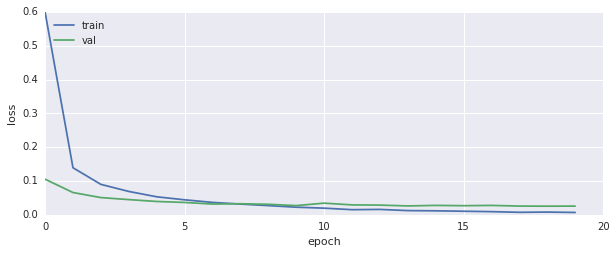

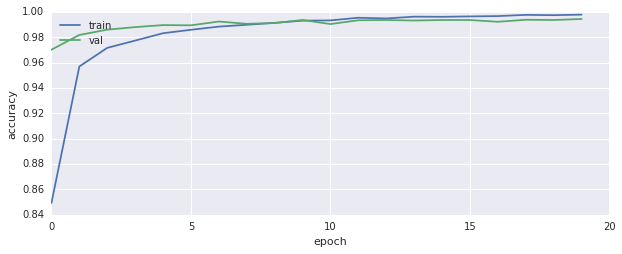

CPU times: user 3h 46min 28s, sys: 15min 9s, total: 4h 1min 37s
Wall time: 30min 19s


In [0]:
%%time 

# Create a ConvNet classifier with 2 CONV-RELU-POOL layers, with filter sizes of 
# 5 and 5 and 32 and 64 output features.
model_params = {
    'input_size': 784,
    'output_size': 10,
    'filter_sizes': [5, 5],
    'output_depths': [32, 64],
    'use_batch_norm': False
}

training_params = {
    'keep_prob': 0.5,
    'num_epochs': 20,
    'batch_size': 50,
    'stop_early': False,
}

trained_model, training_results = build_train_eval_and_plot(
    model_params, 
    training_params, 
    verbose=True
)

The ConvNet classifier takes quite a long time to train, but gives a very respectable test accuracy of over **99%**! 

# Aside: The Effect of Random Initialization
Initialization of model parameters matters! Here is a ConvNet with different, but seemingly sensible, initialization of the weights in the linear layer. Running this gives significantly worse results. Judging by the accuracy plot, it's possible that training this model long enough will get it to a simliar level as before, but it will take much longer. This shows that initialization of model parameters is a an important consideration, especially as models become more complex. 

Epoch: 0001 Training cost= 95.223685306
Epoch: 0001 Validation acc= 0.323000014
Epoch: 0002 Training cost= 4.522310467
Epoch: 0002 Validation acc= 0.294400007
Epoch: 0003 Training cost= 3.359841522
Epoch: 0003 Validation acc= 0.372599989
Epoch: 0004 Training cost= 2.702690359
Epoch: 0004 Validation acc= 0.417400002
Epoch: 0005 Training cost= 2.234992374
Epoch: 0005 Validation acc= 0.439799994
Epoch: 0006 Training cost= 1.954660964
Epoch: 0006 Validation acc= 0.479999989
Epoch: 0007 Training cost= 1.770798251
Epoch: 0007 Validation acc= 0.509599984
Epoch: 0008 Training cost= 1.644968104
Epoch: 0008 Validation acc= 0.519200027
Epoch: 0009 Training cost= 1.517993350
Epoch: 0009 Validation acc= 0.584399998
Epoch: 0010 Training cost= 1.381812039
Epoch: 0010 Validation acc= 0.646399975
Epoch: 0011 Training cost= 1.280346963
Epoch: 0011 Validation acc= 0.657599986
Epoch: 0012 Training cost= 1.202895438
Epoch: 0012 Validation acc= 0.695400000
Epoch: 0013 Training cost= 1.134407729
Epoch: 0013 

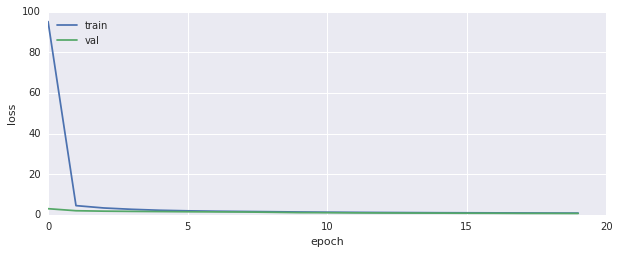

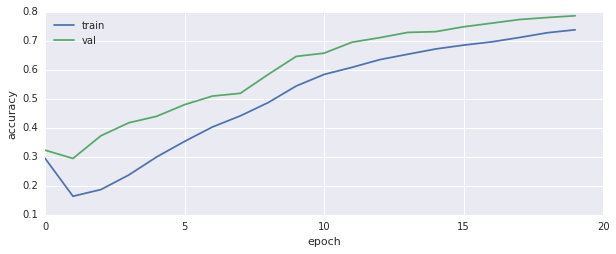

CPU times: user 3h 38min 22s, sys: 14min 55s, total: 3h 53min 18s
Wall time: 29min 29s


In [0]:
%%time 

# Create a ConvNet classifier with 2 CONV-RELU-POOL layers, with filter sizes of 
# 5 and 5 and 32 and 64 output features.
model_params = {
    'input_size': 784,
    'output_size': 10,
    'filter_sizes': [5, 5],
    'output_depths': [32, 64],
    'use_batch_norm': False,
    'linear_weights_initializer': tf.random_normal_initializer()
}

training_params = {
    'keep_prob': 0.5,
    'num_epochs': 20,
    'batch_size': 50,
    'stop_early': False,
}

trained_model, training_results = build_train_eval_and_plot(
    model_params, 
    training_params, 
    verbose=True
)

## Batch Normalisation
Batch normalisation (batch norm) is a more recent (2015) and arguably more powerful normalisation technique than dropout. It is based on the observation that machine learning models often perform better and train faster when their inputs are normalised to have 0 mean and unit variance. In multi-layered deep neural networks, the output of one layer becomes the input to the next. The insight behind batch norm is that each of these layer inputs can also be normalised. Batch norm has been shown to have numerous benefits including:
* Networks tend to train faster
* Allows higher learning rates to be used (further improving training speed).
* Reduced sensitivity to weight initialisation.
* Makes certain activation functions feasible in deep networks (When inputs have very large (absolute) expected values, certain activation functions become saturated (For example, the output of sigmoid is always to 1 for large inputs). Relu activations can also "die out" when the expected value of the input is a large negative value (why?). This results in wasted computation as these neurons become uninformative. Normalising the inputs to have 0 mean keeps these activation functions in the "sensible" parts of their domains.)

### How does it work? 
To normalise some inputs X, ideally we would like to set
$\hat X = \frac{X - E[X]}{\sqrt{VAR[X]}}$
but this requires knowledge of the population mean and variance statistics, which we don't know, at least during training. We therefore use the **sample mean** and **sample variance** of each batch encountered during training as unbiased estimates of these statistics. During testing, we use statistics gathered throughout training as better estimates of the population statistics. In addition to this, we would like the model to have some flexibility over the extent to which batch norm is applied, and this flexibility should be learned! In order to do this, we introduce two new trainable parameters, $\gamma$ and $\beta$ for each layer that batch norm is applied to. Suppose we have a batch of inputs to a layer, $B={x_1,...,x_m}$, we normalise these as follows: 

$\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i$ &nbsp;&nbsp;&nbsp; (Batch mean)

${\sigma_B}^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2$ &nbsp;&nbsp;&nbsp; (Batch variance)
 
$\hat x_i= \frac{x_i - \mu_B}{\sqrt{{\sigma_B}^2}}$ &nbsp;&nbsp;&nbsp; (Normalised)

$y_i = \gamma \hat x_i + \beta$ &nbsp;&nbsp;&nbsp; (Scale and shift)


At test time, we normalise using the mean and variance computed over the entire training set:

$E[x] = E_B[\mu_B]$

$VAR[x] = \frac{m}{m-1}E_B[{\sigma_B}^2]$

$\hat x = \frac{x - E[x]}{\sqrt{VAR[x]}}$

$y = \gamma \hat x + \beta$

### Implementation Details
Tracking the mean and variance over the training set can become a little fiddly. Many implementations also use a *moving average* of the batch mean and variance as estimates of the population mean and variance for use during testing. Luckily, TensorFlow provides batch norm out of the box in the form of the `tf.contrib.layers.batch_norm` function. 

Since the behaviour of batch norm changes during training and testing, we need to pass a placeholder input to the function that indicates which phase we are in. Furthermore, the batch norm function uses variable updates to track the moving average mean and variance. These values are not used during training and so TensorFlow's graph execution logic will not naturally run these updates when you run a training step. In order to get around this, the `batch_norm` function adds these update ops to a *graph collection* that we can access in our training function. The following code, which you will see in the `train_tf_model` function retrieves these ops and then adds a *control dependency* to the optimiser step. This effectively tells TensorFlow that the update_ops must be run before the optimizer_step can be run, ensuring that the estimates are updated whenever we do a training step. 

```
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
  optimizer_step = optimizer_fn.minimize(loss)
```

Further choices to consider when using batch norm are where to apply it (some apply it immediately before each activation function, some *after* the activation function), whether to apply it to all layers and whether or not to *share* the gamma and beta parameters over all layers or have separate values for each layer. . 

Have a look at the ConvNetClassifer class above to see what choices were made, try changing these and see what results you get! (See the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm) for a list of even more parameters you can experiment with)

Now, finally, let's switch batch norm on and see how our ConvNetClassifier performs. (Note: we shouldn't expect it to necessarily perform better than dropout as we are already close to the limits of how well we can classify MNIST with our relatively small ConvNet!)


Epoch: 0001 Training cost= 0.316522977
Epoch: 0001 Validation acc= 0.127800003
Epoch: 0002 Training cost= 0.099678086
Epoch: 0002 Validation acc= 0.174600005
Epoch: 0003 Training cost= 0.062110167
Epoch: 0003 Validation acc= 0.677200019
Epoch: 0004 Training cost= 0.046187922
Epoch: 0004 Validation acc= 0.949800014
Epoch: 0005 Training cost= 0.036256776
Epoch: 0005 Validation acc= 0.981000006
Epoch: 0006 Training cost= 0.026549975
Epoch: 0006 Validation acc= 0.984600008
Epoch: 0007 Training cost= 0.021220099
Epoch: 0007 Validation acc= 0.989600003
Epoch: 0008 Training cost= 0.018451589
Epoch: 0008 Validation acc= 0.991999984
Epoch: 0009 Training cost= 0.015217619
Epoch: 0009 Validation acc= 0.991800010
Epoch: 0010 Training cost= 0.013219205
Epoch: 0010 Validation acc= 0.989799976
Epoch: 0011 Training cost= 0.010857335
Epoch: 0011 Validation acc= 0.990999997
Epoch: 0012 Training cost= 0.009771569
Epoch: 0012 Validation acc= 0.991400003
Epoch: 0013 Training cost= 0.008388710
Epoch: 0013 V

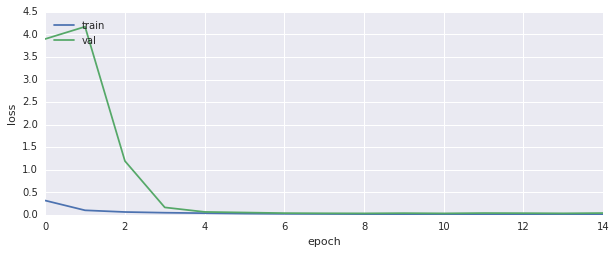

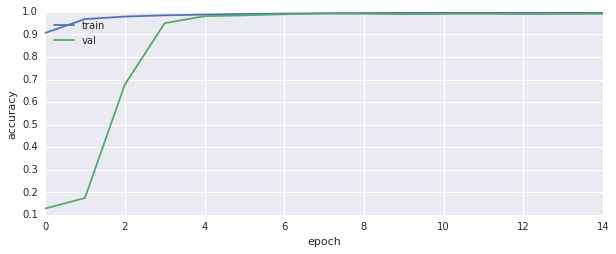

CPU times: user 5h 23min 49s, sys: 16min 2s, total: 5h 39min 51s
Wall time: 14min 30s


In [0]:
%%time 

# Create a ConvNet classifier with 2 CONV-RELU-POOL layers, with filter sizes of 
# 5 and 5 and 32 and 64 output features.
model_params = {
    'input_size': 784,
    'output_size': 10,
    'filter_sizes': [5, 5],
    'output_depths': [32, 64],
    'use_batch_norm': True,
}

training_params = {
    'keep_prob': 1.0,  # Switch off dropout
    'num_epochs': 15,
    'batch_size': 50,
    'stop_early': False,
}

trained_model, training_results = build_train_eval_and_plot(
    model_params, 
    training_params, 
    verbose=True
)

# QUESTION: Try experimenting with different archictures and hyperparameters and 
# see how well you can classify MNIST digits! 

# Additional resources

* Chip Huyen's wonderful script: https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/examples/07_convnet_mnist.py
* NVidia's ConvNet Tutorial: https://github.com/alrojo/tensorflow-tutorial/blob/master/lab2_CNN/lab2_CNN.ipynb
* https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab2/lab2_CNN.ipynb